In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Seed the same set of random numbers
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the Alpaca api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()


# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")


# api = tradeapi.REST()
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [4]:
# Get all Asstes
assets = api.list_assets()
list_of_tickers = ["SPY", "AGG"]


# Set timeframe to '1D'
timeframe = '1D'


# Set start and end datetimes of 1 year, between now and 365 days ago.
# Alpaca api has a limitation for 5 months of data only

start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()
# end_date = datetime.now()
# start_date = end_date + timedelta(-365)


# Get 1 year's worth of historical data for AGG and SPY
df = api.get_barset(
    list_of_tickers,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.sort_index(inplace=True)
df.head()

AGG                                          \
                             open     high       low    close      volume   
2019-01-02 00:00:00-05:00  106.55  106.610  106.4701  106.585  10164756.0   
2019-01-03 00:00:00-05:00  106.57  107.075  106.5700  107.020   6260265.0   
2019-01-04 00:00:00-05:00  106.66  106.720  106.5500  106.695   7755476.0   
2019-01-07 00:00:00-05:00  106.72  106.790  106.4600  106.470   6545877.0   
2019-01-08 00:00:00-05:00  106.40  106.530  105.5300  106.420   3818241.0   

                              SPY                                     
                             open    high     low   close     volume  
2019-01-02 00:00:00-05:00  245.98  251.21  245.95  249.89  107236613  
2019-01-03 00:00:00-05:00  248.23  248.57  244.03  244.46  113782919  
2019-01-04 00:00:00-05:00  247.59  253.11  247.17  252.41  122528832  
2019-01-07 00:00:00-05:00  252.69  255.95  251.69  254.40   88317608  
2019-01-08 00:00:00-05:00  256.82  257.31  254.00  256.65   88864452

In [5]:
# Check columns
df.columns

MultiIndex([('AGG',   'open'),
            ('AGG',   'high'),
            ('AGG',    'low'),
            ('AGG',  'close'),
            ('AGG', 'volume'),
            ('SPY',   'open'),
            ('SPY',   'high'),
            ('SPY',    'low'),
            ('SPY',  'close'),
            ('SPY', 'volume')],
           )

In [6]:
# Keep close prices only
df = df[[('AGG', 'close'), ('SPY', 'close')]]
df.index = df.index.date
df.tail()

,AGG,SPY
,close,close
2019-12-24,112.375,321.26
2019-12-26,112.480,322.91
2019-12-27,112.620,322.86
2019-12-30,112.630,321.10
2019-12-31,112.370,321.92


# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [7]:
# Calculate the daily roi for the stocks
daily_return_df = df.pct_change()
daily_return_df.tail()

,AGG,SPY
,close,close
2019-12-24,0.001292,0.000125
2019-12-26,0.000934,0.005136
2019-12-27,0.001245,-0.000155
2019-12-30,0.000089,-0.005451
2019-12-31,-0.002308,0.002554


In [8]:
# Calculate volatility
daily_return_df.std()

AGG  close    0.002089
SPY  close    0.007820
dtype: float64

In [9]:
avg_daily_return_AGG = daily_return_df.mean()['AGG']['close']
avg_daily_return_SPY = daily_return_df.mean()['SPY']['close']

print(avg_daily_return_AGG)
print(avg_daily_return_SPY)

sd_daily_return_AGG = daily_return_df.std()['AGG']['close']
sd_daily_return_SPY = daily_return_df.std()['SPY']['close']

print(sd_daily_return_AGG)
print(sd_daily_return_SPY)

0.00021276976507473064
0.0010401250682146959
0.0020886019741764646
0.007820053413439366


In [10]:
# Save the last day's closing price
AGG_last_price = df['AGG']['close'][-1]
SPY_last_price = df['SPY']['close'][-1]

print(AGG_last_price)
print(SPY_last_price)

112.37
321.92


In [11]:
# Run the Monte Carlo Simulation

# Set number of simulations and trading days for 30 years
num_simulations = 500
num_trading_days = 252 * 30


# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

# Run the simulation of projecting stock prices for the next 30 trading year
for n in range(num_simulations):

    # Initialize the simulated prices list with the last closing price of `JNJ` and `MU`
    AGG_prices = [AGG_last_price]
    SPY_prices = [SPY_last_price]
    
    # Simulate the returns for 252 days * 30 years
    for _ in range(num_trading_days):
        
        # Append the simulated price to the list
        AGG_prices.append(AGG_prices[-1] * (1 + np.random.normal(avg_daily_return_AGG, sd_daily_return_AGG)))
        SPY_prices.append(SPY_prices[-1] * (1 + np.random.normal(avg_daily_return_SPY, sd_daily_return_SPY)))
    
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["AGG prices"] = pd.Series(AGG_prices)
    simulated_price_df["SPY prices"] = pd.Series(SPY_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (40% AGG; 60% SPY)
    weights = [0.4, 0.6]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

In [12]:
# Print records from the DataFrame
portfolio_cumulative_returns

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000475,1.000537,0.998808,1.005395,1.011797,0.994452,0.997250,1.013277,1.000868,0.995376,...,1.002066,0.992709,1.001800,1.002671,0.996472,1.003160,1.001638,1.006801,0.998172,0.994766
2,1.008876,1.004700,1.003591,0.996711,1.009570,0.994247,0.994213,1.007201,1.000225,0.993035,...,1.005758,0.994517,1.003317,1.006181,0.997472,0.991774,1.002764,1.005409,0.996137,0.998871
3,1.008286,1.004228,1.003771,0.998233,1.007751,0.987669,0.998228,1.001363,1.000230,1.001277,...,1.006771,0.988443,1.004117,1.010565,0.993294,0.994454,1.008272,0.999144,0.998655,1.003329
4,1.013962,1.006575,1.008494,1.002636,1.013663,0.990972,1.003241,0.995493,1.002048,1.006035,...,1.004196,0.992122,1.004723,1.004422,0.994844,0.993782,1.005723,1.002248,0.996963,1.004095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,192.198632,173.061915,175.536542,137.184495,174.087276,406.898297,103.715503,207.335040,179.851038,154.485316,...,205.794078,209.597094,201.019313,150.405526,211.474529,419.025393,175.585603,465.203342,135.029922,207.278177
7557,191.796295,171.335698,175.073322,137.168852,174.462336,406.829966,103.095585,209.131281,179.936157,153.301078,...,205.522019,208.967028,201.668852,149.199635,211.588511,421.932597,175.990087,466.851578,135.447343,206.876247
7558,191.217898,171.137531,175.864455,137.377557,173.873490,408.572982,103.151109,209.957651,180.769205,153.380322,...,205.679462,209.612623,202.344679,148.768826,212.614164,422.012395,176.024377,463.429554,134.469736,207.289917
7559,190.859975,171.029260,176.121496,137.739761,175.432388,406.560889,102.902693,209.654533,179.742836,153.250418,...,206.056113,210.666825,201.151747,148.821403,213.780900,421.115650,176.285521,462.220129,133.666973,206.401943


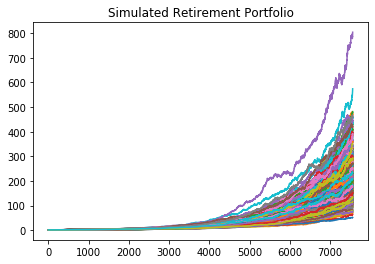

In [13]:
# Visualize cumulative returns
portfolio_cumulative_returns.plot(legend=None, title="Simulated Retirement Portfolio")

In [14]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
# portfolio_cumulative_returns.iloc[-1,:]
ending_return = portfolio_cumulative_returns.tail(1).T
ending_return

,7560
0,192.769939
1,171.963857
2,177.992293
3,138.460439
4,175.622694
...,...
495,421.158099
496,176.158309
497,459.010501
498,134.125079


In [15]:
# Display the 90% confidence interval for the ending returns
confidence_interval = ending_return.quantile(q=[0.05, 0.95])
confidence_interval

,7560
0.05,102.825245
0.95,379.342101


<Figure size 432x288 with 0 Axes>

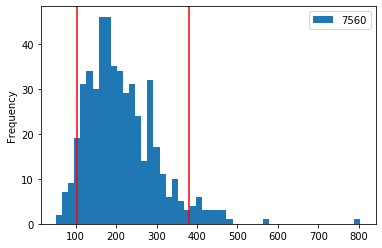

In [16]:
# Visualize the distribution of the ending returns
# Use the `plot` function to create a probability distribution histogram of simulated ending prices
# with markings for a 90% confidence interval
plt.figure()
ending_return.plot(kind='hist', bins=50)
plt.axvline(confidence_interval.iloc[0,0], color='r')
plt.axvline(confidence_interval.iloc[1,0], color='r')

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [17]:
# YOUR CODE HERE
ending_return.quantile(q=[0.1, 0.5, 0.9])

,7560
0.1,119.029858
0.5,199.089970
0.9,320.549831


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [18]:
# Expected portfolio return
initial_investment = 20000
initial_investment * ending_return.quantile(q=[.1, .5, .9])


,7560
0.1,2.380597e+06
0.5,3.981799e+06
0.9,6.410997e+06


### Calcuate a 4% withdraw rate from the retirement portfolio at the 10th percentile

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [19]:
# Calculate the 4% withdrawal for the ending return as retirement income
.04 * (initial_investment * ending_return.quantile(.1)).iloc[0]

95223.88626984837

### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [20]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount
.04 * (1.5 * initial_investment * ending_return.quantile(.1)).iloc[0]

142835.82940477255

### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [21]:
# Calculate projected returns in 30 years
projected_returns = portfolio_cumulative_returns.quantile(q=[0.05, .5, .95], axis=1, numeric_only=True).T.head()

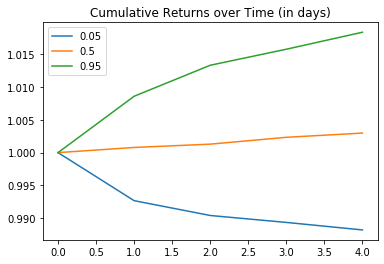

In [22]:
# Plot projected returns
projected_returns.plot(title="Cumulative Returns over Time (in days)")

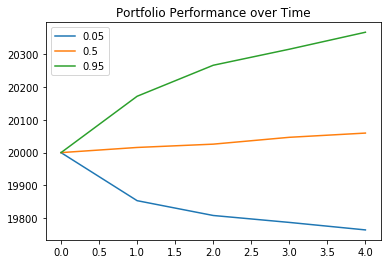

In [23]:
# Plot projected returns in dollars
(initial_investment * projected_returns).plot(title="Portfolio Performance over Time")